# Convex MPC and QP

## Functions

In [1]:
from cvxpy import *
import numpy as np
import scipy as sp
from scipy import sparse


In [2]:
def hatmap(w):
  # Transforms an R3 vector to a skew-symmetric matrix

  w_hat = np.matrix([[0, -w[2], w[1]],
                     [w[2], 0, -w[0]],
                     [-w[1], w[0], 0]])
  
  return w_hat

In [3]:
def get_Rz(psi = 0):
  # Rotation from body to world coordinates R = Rz*Ry*Rx
  # For small values of roll and pitch, R is approx. Rz

  Rz = np.matrix([[np.cos(psi), np.sin(psi), 0], 
               [-np.sin(psi), np.cos(psi), 0],
               [0,            0,           1]])
  
  return Rz

In [4]:
def get_I_approx(Ixx, Iyy, Izz, Rz, psi):
  """
    Args: 
      Ixx, Iyy, Izz: Inertia components in body coordinates
      psi: yaw angle, x.item(2) in cvxpy state vector variable

    Return:
      I : Approximation of inertia tensor in the world coordinate system
  """

  # Inertia tensor in body coordinates
  I_B = np.matrix([[Ixx, 0,   0],
                  [0,   Iyy, 0],
                  [0,   0,   Izz]])
  
  I = Rz*I_B*np.transpose(Rz) 

  return I

In [5]:
def get_A(psi, gravity_state): 
  """
    Args:
      psi: yaw angle, x.item(2) in cvxpy state vector variable

      gravity_state: Boolean, True if gravity state is added to state vector
       adds zero row to Bottom of A and column vector with a 1 corresponding to the
       d/dt(p_dot_z) row

    Return:
      A: Continuous Time Approx of Orientation and Translation Dynamics, State Matrix A 
  """

  zeros_3 = np.asmatrix(np.zeros((3,3)))
  id_3 = np.asmatrix(np.eye(3))

  Rz = get_Rz(psi) 

  A = np.asmatrix(np.vstack([np.hstack([zeros_3,zeros_3, Rz, zeros_3]),
                          np.hstack([zeros_3, zeros_3, zeros_3, id_3]),
                          np.hstack([zeros_3, zeros_3, zeros_3,zeros_3]),
                          np.hstack([zeros_3, zeros_3, zeros_3,zeros_3])]))
  
  if gravity_state == True:
    zero_row = np.zeros((1,12))
    g_column = np.transpose(np.matrix([0,0,0,0,0,0,0,0,0,0,0,1,0]))
    A = np.hstack([np.vstack([A, zero_row]),g_column])

  return A

In [6]:
def get_B(psi, r, gravity_state):
  """
    Args:
      m: mass
      psi: yaw angle, x.item(2) in cvxpy state vector variable
      r: list of feet position

      gravity_state: Boolean, True if gravity state is added to state vector
        adds zero row to bottom of B

    Return:
      B: Continuous Time Approx of Orientation and Translation Dynamics, Control B Matrix 
  """

  zeros_3 = np.asmatrix(np.zeros((3,3)))
  id_3 = np.asmatrix(np.eye(3))

  Rz = get_Rz(psi)
  I = get_I_approx(Ixx, Iyy, Izz, Rz, psi)
  I_inv = np.linalg.inv(I)

  B = np.asmatrix(np.vstack([np.hstack([zeros_3,zeros_3, zeros_3, zeros_3]),
                          np.hstack([zeros_3, zeros_3, zeros_3, zeros_3]),
                          np.hstack([I_inv@hatmap(r[0]), I_inv@hatmap(r[1]), I_inv@hatmap(r[2]), I_inv@hatmap(r[3])]),
                          np.hstack([id_3/m, id_3/m, id_3/m,id_3/m])])) 

  if gravity_state == True:
    zero_row = np.zeros((1,12))
    B = np.vstack([B, zero_row])

  return B

In [7]:
def get_Ax(Ad_list,nx,N):
  """
  Helper Function for building Ax matrix for fixed or changing Ad over horizon N

  If len(Ad_list) > 1, len(Ad_list) must = N

  """

  if len(Ad_list) == 1: # linear dynamics matrix A is fixed over horizon
    Ax = sparse.kron(sparse.eye(N+1),-sparse.eye(nx)) + sparse.kron(sparse.eye(N+1, k=-1), Ad_list[0])
  else:
    temp_block = sparse.block_diag(Ad_list, format='csc')
    top_row = sparse.csc_matrix((nx,nx*N))
    r_col = sparse.csc_matrix(((N+1)*nx, nx))
    off_diag_Ax = sparse.hstack([sparse.vstack([top_row,temp_block]),r_col])

    Ax = sparse.kron(sparse.eye(N+1),-sparse.eye(nx)) + off_diag_Ax

  return Ax

In [8]:
def get_Bu(Bd_list,nx,nu,N):
  """
  Helper Function for building Bu matrix for fixed or changing Bd over horizon N

  If len(Bu_list) > 1, len(Bu_list) must = N

  """

  if len(Bd_list) == 1: # linear dynamics matrix B is fixed over horizon
    Bu = sparse.kron(sparse.vstack([sparse.csc_matrix((1, N)), sparse.eye(N)]), Bd_list[0])
  else:
    Bu = sparse.vstack([sparse.csc_matrix((nx, N*nu)), sparse.block_diag(Bd_list, format='csc')])

  return Bu


In [9]:
def umin1(u_j):
  # Trot Gait Phase 1 lower bounds (FR and BL in contact, FL and BR in air)
  umin_1 = np.array([
                 -mu*u_j[2],  #FR_x
                 -mu*u_j[2],  #FR_y
                 fmin,        #FR_z
                 0,           #FL_x
                 0,           #FL_y
                 0,           #FL_z
                 0,           #BR_x
                 0,           #BR_y
                 0,           #BR_z
                 -mu*u_j[11], #BL_x
                 -mu*u_j[11], #BL_y
                 fmin,        #BL_z
                 ])   
  return umin_1

def umax1(u_j):
  # Trot Gait Phase 1 upper bounds  (FR and BL in contact, FL and BR in air)
  umax_1 = np.array([
                  mu*u_j[2],  #FR_x
                  mu*u_j[2],  #FR_y
                  fmax,       #FR_z
                  0,          #FL_x
                  0,          #FL_y
                  0,          #FL_z
                  0,          #BR_x
                  0,          #BR_y
                  0,          #BR_z
                  mu*u_j[11], #BL_x
                  mu*u_j[11], #BL_y
                  fmax,       #BL_z
                  ])   
  return umax_1

def umin2(u_j):
  # Trot Gait Phase 2 lower bounds  (FL and BR in contact, FR and BL in air)
  umin_2 = np.array([
                  0,          #FR_x
                  0,          #FR_y
                  0,          #FR_z
                  -mu*u_j[5], #FL_x
                  -mu*u_j[5], #FL_y
                  fmin,       #FL_z
                  -mu*u_j[8], #BR_x
                  -mu*u_j[8], #BR_y
                  fmin,       #BR_z
                  0,          #BL_x
                  0,          #BL_y
                  0,          #BL_z
                  ])   
  
  return umin_2

def umax2(u_j):
  # Trot Gait Phase 2 upper bounds (FL and BR in contact, FR and BL in air)
  umax_2 = np.array([
                  0,         #FR_x
                  0,         #FR_y
                  0,         #FR_z
                  mu*u_j[5], #FL_x
                  mu*u_j[5], #FL_y
                  fmax,      #FL_z
                  mu*u_j[8], #BR_x
                  mu*u_j[8], #BR_y
                  fmax,      #BR_z
                  0,         #BL_x
                  0,         #BL_y
                  0,         #BL_z
                  ])   
  return umax_2

def feet_constraint_builder_osqp(gait_phase, gait_phase_len, N, nsim_iter, state_controls_vec):
  """
  Args:
    gait_phase: list of phases for a gait cycle with each phase being a list of 
      constraint functions for the controls in the form [umin(),umax()]
    
    gait_phase_len: number of time steps to complete a single phase in the 
      gait cycle
    
    N: Horizon length

    nsim_iter: current step in the closed loop simulation

    state_controls_vec: vector of all states and controls provided by OSQP prob.solve, res.x

  Return:
    new_lineq, new_uineq : new lower bound and upper bound inequality vectors

  """

  lower_bounds_list = []
  upper_bounds_list = []

  # Obtains each control vector in horizon and builds constraints
  for j in range(N):
    if -(N-1)*nu+j*N == 0:
      u_j = state_controls_vec[-N*nu+j*N:]
    else:
      u_j = state_controls_vec[-N*nu+j*N:-(N-1)*nu+j*N]

    phase_idx = ((j+nsim_iter)//gait_phase_len)%len(gait_phase)
    #print(phase_idx)

    # Check for valid lower and upper bounds
    # l_test = gait_phase[phase_idx][0](u_j)
    # u_test = gait_phase[phase_idx][1](u_j)
    # for i in range(len(l_test)):
    #   if l_test[i] > u_test[i]:
    #     print("For Phase {}".format(phase_idx))
    #     print("For control vector at step {} in the horizon".format(j))
    #     print("lower bound is higher than upper bound at idx:", i)
    #     print(u_j)
    #     print("lower bound: {}, upper bound {}".format(l_test[i], u_test[i]))
    #     print("#########################################")

    # abs(u_j) is used when building the constraint list as all normal forces (z_component) should be 0 or a bounded positive value,
    # However, when transitioning from a gait phase where select feet force constraints are set to zero, there
    # may be marginally negative (ie. -1e-6) forces observed since the controls cannot be absolutly gauranteed,
    lower_bounds_list.append(gait_phase[phase_idx][0](np.abs(u_j))) 
    upper_bounds_list.append(gait_phase[phase_idx][1](np.abs(u_j)))

  new_lineq = np.hstack(lower_bounds_list)
  new_uineq = np.hstack(upper_bounds_list)
  
  return new_lineq, new_uineq

In [12]:
def get_DiscreteTimeDynamics(A,B,h):
  """
    Returns:
      Ad,Bd : Discrete Time Dynamics 
  """

  [nx, nu] = B.shape

  # Build State Transition Model
  null_mat_of_stm = np.matrix(np.zeros((nu,nx+nu)))
  state_transition_matrix = np.vstack([np.hstack([A,B]),null_mat_of_stm])

  # Exponential Matrix of STM
  exp_stm = sp.linalg.expm(state_transition_matrix*h)

  Ad = exp_stm[:nx,:nx]
  Bd = exp_stm[:nx,nx:]

  # Euler Approx 
  # Ad = sparse.csc_matrix(np.eye(A.shape[0]) + A*h)
  # Bd = sparse.csc_matrix(B*h)

  # RK4 ZOH
  
  return Ad,Bd

In [13]:
def full_sim_ref_traj_generator(x_ref_list, nsim):
  """
  Generate Evenly timed reference trajectories for the closed loop sim

  """
  full_sim_ref_trajectories = np.vstack([[x_ref_list[i]]*int(nsim/len(x_ref_list)) for i in range(len(x_ref_list))])

  return full_sim_ref_trajectories

def horizon_ref_traj_generator(full_sim_trajectories, N, nsim_iter):
  """
  Generate Evenly timed reference trajectories for the closed loop sim
  and provide the reference trajectories for the current horizon:

  """
  horizon_ref_traj = full_sim_trajectories[nsim_iter:N+nsim_iter,:]
  # horizon_ref_traj will be shorter than horizon at end of sim 
  # duplicate final reference until sim ends
  while len(horizon_ref_traj) < N:
    horizon_ref_traj = np.vstack([horizon_ref_traj, horizon_ref_traj[-1,:]]) 

  return horizon_ref_traj


In [14]:
def get_ref_trajectories(desired_movement, nsim):
  """
  Builds reference trajectories from a list of possible options being:
  ["stationary", "raise_base", "move_forward", "square_movement", "move_left", "move_right"]

  Args:
    desired_movement: string from list above

  Returns: 
    full_sim_trajectories
  """
  xr_raise_base = np.array([0.,0.,0.,0.,0.,body_height+0.1,0.,0.,0.,0.,0.,0.,-9.81])
  raise_base_ref_list = [xr_raise_base]

  xr_stand = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,0.,0.,-9.81])
  stand_ref_list = [xr_stand]

  xr_forward = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,2.,0.,0.,-9.81])
  forward_ref_list = [xr_forward]

  xr_left = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,-2.,0.,-9.81])
  left_ref_list = [xr_left]

  xr_right = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,2.,0.,-9.81])
  right_ref_list = [xr_right]

  xr_sq1 = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,2.,0.,0.,-9.81])
  xr_sq2 = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,2.,0.,-9.81])
  xr_sq3 = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,-2.,0.,0.,-9.81])
  xr_sq4 = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,-2.,0.,-9.81])
  square_ref_list = [xr_sq1, xr_sq2, xr_sq3, xr_sq4]

  options_dict = {"stationary":stand_ref_list, "raise_base": raise_base_ref_list, 
                  "square_movement":square_ref_list, "move_forward":forward_ref_list,
                  "move_left":left_ref_list, "move_right":right_ref_list,}

  selected_ref_traj = options_dict[desired_movement]

  full_sim_ref_trajectories = full_sim_ref_traj_generator(selected_ref_traj, nsim)

  return full_sim_ref_trajectories

In [15]:
def get_intial_control_constraints():

  # Initial Control Contsraints, updated after step 1
  umin = np.array([-np.inf,  #FR_x
                  -np.inf,  #FR_y
                  fmin,     #FR_z
                  -np.inf,  #FL_x
                  -np.inf,  #FL_y
                  fmin,     #FL_z
                  -np.inf,  #BR_x
                  -np.inf,  #BR_y
                  fmin,     #BR_z
                  -np.inf,  #BL_x
                  -np.inf,  #BL_y
                  fmin,     #BL_z
                  ])   

  umax = np.array([np.inf,  #FR_x
                  np.inf,  #FR_y
                  fmax,    #FR_z
                  np.inf,  #FL_x
                  np.inf,  #FL_y
                  fmax,    #FL_z
                  np.inf,  #BR_x
                  np.inf,  #BR_y
                  fmax,    #BR_z
                  np.inf,  #BL_x
                  np.inf,  #BL_y
                  fmax,    #BL_z
                  ])   
  
  return umin,umax


In [16]:
def get_update_constraint_matrix_A(horizon_ref_traj,r,h):
  """
  Updates Constraint Matrix at each step in the sim
  """

  # Continuous Time Model
  A = get_A(np.mean(horizon_ref_traj[:,2]), gravity_state=True)
  B = get_B(horizon_ref_traj[0,2], r, gravity_state=True)
  [nx, nu] = B.shape

  Ad, Bd = get_DiscreteTimeDynamics(A,B,h)

  # - linear dynamics 
  Ax = get_Ax([Ad],nx,N)
  Bu = get_Bu([Bd],nx,nu,N)
  Aeq = sparse.hstack([Ax, Bu])

  # - input and state constraints
  Aineq = sparse.eye((N+1)*nx + N*nu)

  A_c = sparse.vstack([Aeq, Aineq], format='csc')

  return A_c

In [10]:
import matplotlib.pyplot as plt

def state_hist_plots(xhist_list,x_ref_list,nsim,h):
  """
    Return:
      State History Plots with Reference States
  """

  t = np.arange(nsim)*h
  xhist = np.vstack(xhist_list)

  if len(x_ref_list) == 1:
    x_ref_hist = np.vstack([x_ref_list[0]]*len(xhist_list))
  else:
    x_ref_hist = np.vstack(x_ref_list)
  

  fig, axs = plt.subplots(4, 3, figsize = (15,12))
  axs[0, 0].plot(t,xhist[:,0], label = "actual")
  axs[0, 0].plot(t,x_ref_hist[:,0], label = "reference")
  axs[0, 0].legend(loc='upper right')
  axs[0, 0].set_ylabel('Radians')
  axs[0, 0].set_title("$\phi$")
  axs[0, 1].plot(t,xhist[:,1], label = "actual")
  axs[0, 1].plot(t,x_ref_hist[:,1], label = "reference")
  axs[0, 1].legend(loc='upper right')
  axs[0, 1].set_title("$\\theta$")
  axs[0, 2].plot(t,xhist[:,2], label = "actual")
  axs[0, 2].plot(t,x_ref_hist[:,2], label = "reference")
  axs[0, 2].legend(loc='upper right')
  axs[0, 2].set_title("$\psi$")

  axs[1, 0].plot(t,xhist[:,3], label = "actual")
  axs[1, 0].plot(t,x_ref_hist[:,3], label = "reference")
  axs[1, 0].set_ylabel('Distance (m)')
  axs[1, 0].legend(loc='upper right')
  axs[1, 0].set_title("$\mathbf{p}_x$")
  axs[1, 1].plot(t,xhist[:,4], label = "actual")
  axs[1, 1].plot(t,x_ref_hist[:,4], label = "reference")
  axs[1, 1].legend(loc='upper right')
  axs[1, 1].set_title("$\mathbf{p}_y$")
  axs[1, 2].plot(t,xhist[:,5], label = "actual")
  axs[1, 2].plot(t,x_ref_hist[:,5], label = "reference")
  axs[1, 2].legend(loc='upper right')
  axs[1, 2].set_title("$\mathbf{p}_z$")

  axs[2, 0].plot(t,xhist[:,6], label = "actual")
  axs[2, 0].plot(t,x_ref_hist[:,6], label = "reference")
  axs[2, 0].set_ylabel('Radians per Second')
  axs[2, 0].legend(loc='upper right')
  axs[2, 0].set_title("$\dot{\phi}$")
  axs[2, 1].plot(t,xhist[:,7], label = "actual")
  axs[2, 1].plot(t,x_ref_hist[:,7], label = "reference")
  axs[2, 1].legend(loc='upper right')
  axs[2, 1].set_title("$\dot{\\theta}$")
  axs[2, 2].plot(t,xhist[:,8], label = "actual")
  axs[2, 2].plot(t,x_ref_hist[:,8], label = "reference")
  axs[2, 2].legend(loc='upper right')
  axs[2, 2].set_title("$\dot{\psi}$")

  axs[3, 0].plot(t,xhist[:,9], label = "actual")
  axs[3, 0].plot(t,x_ref_hist[:,9], label = "reference")
  axs[3, 0].set_ylabel('Velocity (m/s)')
  axs[3, 0].legend(loc='upper right')
  axs[3, 0].set_title("$\dot{\mathbf{p}}_x$")
  axs[3, 1].plot(t,xhist[:,10], label = "actual")
  axs[3, 1].plot(t,x_ref_hist[:,10], label = "reference")
  axs[3, 1].legend(loc='upper right')
  axs[3, 1].set_title("$\dot{\mathbf{p}}_y$")
  axs[3, 2].plot(t,xhist[:,11], label = "actual")
  axs[3, 2].plot(t,x_ref_hist[:,11], label = "reference")
  axs[3, 2].legend(loc='upper right')
  axs[3, 2].set_title("$\dot{\mathbf{p}}_z$")

  fig.text(0.5, -0.02, 'time (s)', ha='center', va='center')

  fig.tight_layout()

  return 

In [11]:
import matplotlib.pyplot as plt

def control_hist_plots(uhist_list,nsim,h):
  """
    Return:
      Control History Plots
  """

  t = np.arange(nsim)*h

  uhist = np.vstack(uhist_list)

  fig, axs = plt.subplots(1, 3, figsize = (15,3))
  axs[0].plot(t,uhist[:,0], label=("$FR$"))
  axs[0].plot(t,uhist[:,3], label=("$FL$"))
  axs[0].plot(t,uhist[:,6], label=("$BR$"))
  axs[0].plot(t,uhist[:,9], label=("$BL$"))
  axs[0].set_ylabel('Force (N)')
  axs[0].legend(loc='upper right')
  axs[0].set_title("$\mathbf{f}_x$")


  axs[1].plot(t,uhist[:,1], label=("$FR$"))
  axs[1].plot(t,uhist[:,4], label=("$FL$"))
  axs[1].plot(t,uhist[:,7], label=("$BR$"))
  axs[1].plot(t,uhist[:,10], label=("$BL$"))
  axs[1].legend(loc='upper right')
  axs[1].set_title("$\mathbf{f}_y$")


  axs[2].plot(t,uhist[:,2], label=("$FR$"))
  axs[2].plot(t,uhist[:,5], label=("$FL$"))
  axs[2].plot(t,uhist[:,8], label=("$BR$"))
  axs[2].plot(t,uhist[:,11], label=("$BL$"))
  axs[2].legend(loc='upper right')
  axs[2].set_title("$\mathbf{f}_z$")

  fig.text(0.5, -0.02, 'time (s)', ha='center', va='center')

  fig.tight_layout()

  return 

In [17]:
import scipy
from scipy import integrate
def is_hurwitz(A, tolerance = 1e-9):

    '''
    (c) Mark W. Mueller 2016, Controlpy

    Test whether the matrix A is Hurwitz (i.e. asymptotically stable).
    
    tolerance defines the minimum distance we should be from the imaginary axis 
     to be considered stable.
    
    '''
    return np.max(np.linalg.eig(A)[0].real) < -np.abs(tolerance)

def controllability_gramian(A, B, T = np.inf):
    '''
    (c) Mark W. Mueller 2016, Controlpy
    
    Compute the causal controllability Gramian of the continuous time system.
    
    The system is described as
     dx = A*x + B*u
     
    T is the horizon over which to compute the Gramian. If not specified, the 
    infinite horizon Gramian is computed. Note that the infinite horizon Gramian
    only exists for asymptotically stable systems.
    
    If T is specified, we compute the Gramian as
     Wc = integrate exp(A*t)*B*B.H*exp(A.H*t) dt 
    
    Returns the matrix Wc.
    '''
    
    assert A.shape[0]==A.shape[1], "Matrix A is not square"
    assert A.shape[0]==B.shape[0], "Matrix A and B do not align"

    if not np.isfinite(T):
        #Infinite time Gramian:
        assert is_hurwitz(A), "Can only compute infinite horizon Gramian for a stable system."
        
        Wc = scipy.linalg.solve_lyapunov(A, -B.dot(B.T))
        return Wc
    
    # We need to solve the finite time Gramian
    # Boils down to solving an ODE:
    A = np.array(A,dtype=float)
    B = np.array(B,dtype=float)
    T = np.float64(T)
    
    def gramian_ode(y, t0, A, B):
        temp = np.dot(scipy.linalg.expm(A*t0),B)
        dQ = np.dot(temp,np.conj(temp.T))
         
        return dQ.reshape((A.shape[0]**2,1))[:,0]
     
    y0 = np.zeros([A.shape[0]**2,1])[:,0]
    out = integrate.odeint(gramian_ode, y0, [0,T], args=(A,B))
    Q = out[1,:].reshape([A.shape[0], A.shape[0]])
    return Q

## Model Parameters

In [18]:
from copy import deepcopy
# Controller Settings and Robot Data from MIT Cheetah 3 
m = 43 # kg 
Ixx = 0.41 # kgm^2 
Iyy = 2.1 # kgm^2
Izz = 2.1 # kgm^2
mu = 0.6 # Coefficient of Friction
g_z = -9.81 # m/s^2

tau_max = 250 # Nm
Θ_weight = 1
z_weight = 50
yaw_rate_weight = 1
v_weight = 1
alpha = 1e-6 # force_weight 
fmin = 10 # N
fmax = 666 # N

body_length = 0.6 # m
body_width = 0.256 # m
body_height = 0.3 #m 
leg_link_lengths = 0.34 # m, both l1 and l2

## QP for MPC Implementation (Python)

In [ ]:
import osqp
import numpy as np
import scipy as sp
from scipy import sparse

# Initialization for Continuos Time Model (Assuming Robot is at rest)

# r is the vector from the center of mass (COM) to the point where the force is applied
# Needed for initialization
r1 = np.array([0.5*body_length, -0.5*body_width, -body_height]) #FR
r2 = np.array([0.5*body_length, 0.5*body_width, - body_height]) #FL
r3 = np.array([-0.5*body_length, - 0.5*body_width, -body_height]) #BR
r4 = np.array([-0.5*body_length, 0.5*body_width, -body_height]) #BL

r = [r1,r2,r3,r4]

# Initial state
x0 = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,0.,0.,-9.81])

# Continuous Time Model
A = get_A(x0[2], gravity_state=True)
B = get_B(x0[2], r, gravity_state=True)
[nx, nu] = B.shape

# Time step h for discritization
h = 1/36

# Prediction horizon
N = 12 #set to 12 for 2 gait cycles if 1 gait cycle is .33 second 

# Desired Simulation Time
sim_time = 2 #seconds
nsim = int(sim_time/h)

# Discrete time model of a quadruped
Ad, Bd = get_DiscreteTimeDynamics(A,B,h)

# Objective function
# Q and R are diagonal positive semidefinite matrices of weights
Q = sparse.diags([1., 1., 1., 1., 1., 50., 1., 1., 1., 1., 1., 1., 1.])
QN = Q
R = alpha*sparse.eye(12)

# Obtain Reference trajectories and reference trajectories for Initial Horizon
#full_sim_ref_trajectories = get_ref_trajectories("square_movement", nsim)
full_sim_ref_trajectories = get_ref_trajectories("move_forward", nsim)
#full_sim_ref_trajectories = get_ref_trajectories("move_right", nsim)
#full_sim_ref_trajectories = get_ref_trajectories("move_left", nsim)
#full_sim_ref_trajectories = get_ref_trajectories("stationary", nsim)
#full_sim_ref_trajectories = get_ref_trajectories("raise_base", nsim)

horizon_ref_traj = horizon_ref_traj_generator(full_sim_ref_trajectories, N, 0)

# State Constraints
xmin = np.array([-np.pi/6, #phi
                 -np.pi/6, #theta
                 -np.pi/6, #psi
                 -np.inf,  #p_x
                 -np.inf,  #p_y
                 body_height-.1,  #p_z
                 -np.inf,  #omega_x
                 -np.inf,  #omega_y
                 -np.inf,  #omega_z
                 -6.0,  #pdot_x
                 -2.0,  #pdot_y
                 -2.0,  #pdot_z
                 -9.81     #g_z
                 ])       

xmax = np.array([np.pi/6, #phi
                 np.pi/6, #theta
                 np.pi/6, #psi
                 np.inf,  #p_x
                 np.inf,  #p_y
                 body_height+.1,  #p_z
                 #np.inf,  #p_z
                 np.inf,  #omega_x
                 np.inf,  #omega_y
                 np.inf,  #omega_z
                 3.0,  #pdot_x
                 2.0,  #pdot_y
                 2.0,  #pdot_z
                 9.81     #g_z
                 ])       


# Convert problem to a QP for OSQP
# - quadratic objective
P = sparse.block_diag([sparse.kron(sparse.eye(N), Q), QN,
                       sparse.kron(sparse.eye(N), R)], format='csc')
# - linear objective
q = np.hstack([np.hstack([-Q.dot(horizon_ref_traj[i,:]) for i in range(N)]), -QN.dot(horizon_ref_traj[-1,:]),np.zeros(N*nu)])

# - linear dynamics 
Ax = get_Ax([Ad],nx,N)
Bu = get_Bu([Bd],nx,nu,N)
Aeq = sparse.hstack([Ax, Bu])

leq = np.hstack([-x0, np.zeros(N*nx)])
ueq = leq

# - input and state constraints
Aineq = sparse.eye((N+1)*nx + N*nu)

umin,umax = get_intial_control_constraints()
lineq = np.hstack([np.kron(np.ones(N+1), xmin), np.kron(np.ones(N), umin)])
uineq = np.hstack([np.kron(np.ones(N+1), xmax), np.kron(np.ones(N), umax)])

# - OSQP constraints 
A_c = sparse.vstack([Aeq, Aineq], format='csc')
l = np.hstack([leq, lineq])
u = np.hstack([ueq, uineq])

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace
prob.setup(P, q, A_c, l, u, warm_start=True, verbose = False, polish=1)

# Trotting Gait (2-Phase)
phase_1 = [umin1,umax1]
phase_2 = [umin2,umax2]

gait_phase = [phase_1,phase_2]
gait_phase_len = 3 # num time steps to complete a phase in the gait cycle, 
                   # if N = 12, and gait has 2 phases, gait_phase_len = 3
                   # means horizon will include 2 gait cycles

# Simulate in closed loop

xhist_list = []
uhist_list = []
x_ref_list = []

# First solve in loop is for stationary robot with all feet active 
# and only enforces state constraints normal force control constraints
# since control horizon is not yet determined
for i in range(nsim):
    # Solve
    res = prob.solve()

    # Check solver status
    if res.info.status != 'solved':
        raise ValueError('OSQP did not solve the problem!')

    xhist_list.append(x0)
    x_ref_list.append(horizon_ref_traj[0])

    # Apply first control input 
    ctrl = res.x[-N*nu:-(N-1)*nu] # res.x contains future states and controls in horizon
    x0 = Ad.dot(x0) + Bd.dot(ctrl) #+ 0.2*np.random.rand(12)

    uhist_list.append(ctrl)

    # Update initial state
    l[:nx] = -x0
    u[:nx] = -x0

    # Update inequality contraints and matrix for horizon
    horizon_ref_traj = horizon_ref_traj_generator(full_sim_ref_trajectories, N, i)
    new_A_c = get_update_constraint_matrix_A(horizon_ref_traj,r,h)

    new_l, new_u = feet_constraint_builder_osqp(gait_phase, gait_phase_len, N, i-1, res.x)
    l[-nu*N:] = new_l
    u[-nu*N:] = new_u


    prob.update(l=l, u=u, Ax=new_A_c.data)
    #prob.update(l=l, u=u)

In [ ]:
res.info.solve_time, res.info.setup_time, res.info.run_time, res.info.status_val, res.info.status_polish, res.info.status

(0.00174087, 0.001231474, 0.009698011, 1, -1, 'solved')

## State History Plots

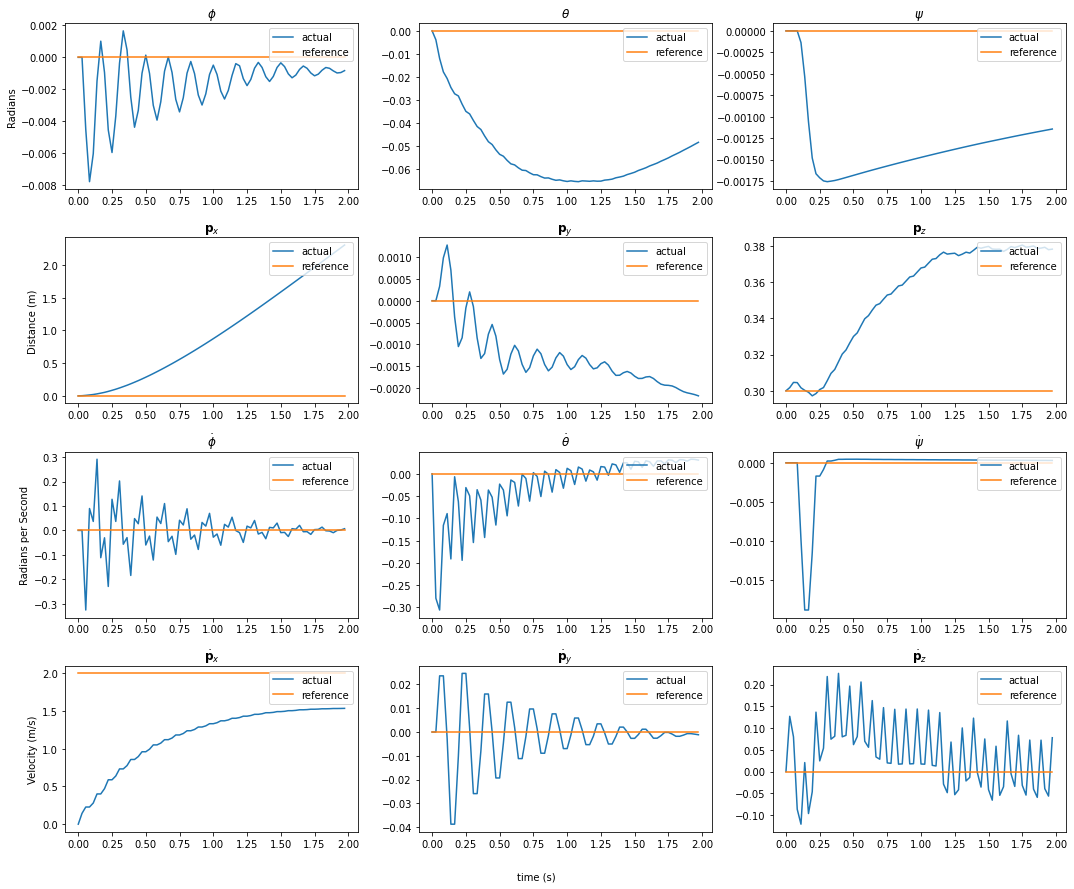

In [ ]:
# Plot State History
state_hist_plots(xhist_list,x_ref_list,nsim,h)

## Control History Plots

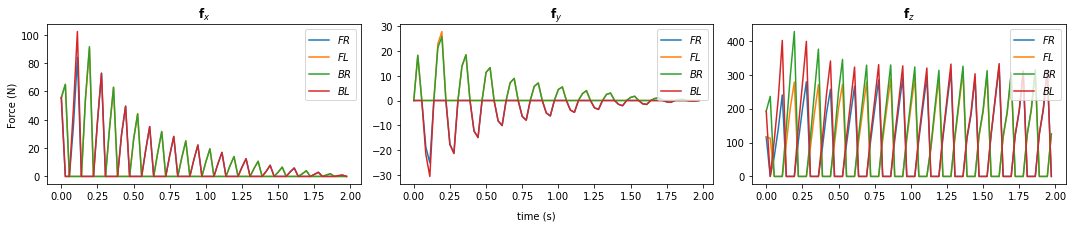

In [ ]:
# Plot Control History
control_hist_plots(uhist_list,nsim,h)

# Test Bench and Incomplete Work:


## Controllabillity Gramian

In [ ]:
x0 = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,0.,0.,-9.81])
A = get_A(x0[2], gravity_state=False)
B = get_B(x0[2], r, gravity_state=False)

e_list = []
# controllability matrix
for i in range (x0.shape[0]):
  e_list.append(A**i@B)

e = np.hstack(e_list)
print("shape of controllability matrix: {}, rank of controllobillity matrix: {}".format(e.shape,np.linalg.matrix_rank(e)))

shape of controllability matrix: (12, 156), rank of controllobillity matrix: 12


In [ ]:
# Infinite Time Controllabillity Gramian (Appears to be less than full rank)

Wc = scipy.linalg.solve_lyapunov(A, -B.dot(B.T))
np.linalg.matrix_rank(Wc) 

/usr/local/lib/python3.8/dist-packages/scipy/linalg/_solvers.py:191: RuntimeWarning: Input "a" has an eigenvalue pair whose sum is very close to or exactly zero. The solution is obtained via perturbing the coefficients.
  warnings.warn('Input "a" has an eigenvalue pair whose sum is '


6

In [ ]:
# Evaluate when Continuous Time System becomes uncontrolable (Highly dependent on initialization of B)

nx,nu = B.shape 

horizon = 10000000
for i in range(1,horizon, 100000):
  if np.linalg.matrix_rank(controllability_gramian(A,B,T=i)) < nx:
    print("Continuos Time System is uncontrolable beyond a horizon of {}".format(i-1))
    break



## Double Integrator (Python)

In [ ]:
import osqp
import numpy as np
import scipy as sp
from scipy import sparse


# Continuous time model of a double integrator
A = np.array([
    [0., 1.],
    [0., 0.]
    ])
                          
B = np.array([
    [0.],
    [1.]
    ])

# Time step h for discritization
h = 0.2 # 5 Hz

# Discrete time model of a double integrator
# Exponential Matrix
# Ad = sparse.csc_matrix(expm(A*h))
# Bd = sparse.csc_matrix(np.linalg.pinv(A)*(np.eye(A.shape[0])-Ad)*B) 


Ad = sparse.csc_matrix([
    [1., h],
    [0., 1.]
    ])

Bd = sparse.csc_matrix([
  [h**2/2],
  [h]])

[nx, nu] = Bd.shape

# Constraints
umin = np.array([-10.])
umax = np.array([3.]) 

xmin = np.array([-np.inf,-np.inf])
xmax = np.array([np.inf,np.inf])

# Objective function
Q = sparse.diags([1., 1. ])
QN = Q
R = 0.001*sparse.eye(1)

# Initial and reference states
x0 = np.array([0.,0.])
xr = np.array([10.,0.]) # need to calculate a ref traj of 0.3 to 0.5 seconds every 0.03 to 0.05 seconds

# Prediction horizon
N = 2

# Convert problem to a QP for OSQP, used for solving convex quadratic programs 
# - quadratic objective
P = sparse.block_diag([sparse.kron(sparse.eye(N), Q), QN,
                       sparse.kron(sparse.eye(N), R)], format='csc')
# - linear objective
q = np.hstack([np.kron(np.ones(N), -Q.dot(xr)), -QN.dot(xr),np.zeros(N*nu)])

# - linear dynamics
Ax = get_Ax([Ad],nx,N)
Bu = get_Bu([Bd],nx,nu,N)
Aeq = sparse.hstack([Ax, Bu])
leq = np.hstack([-x0, np.zeros(N*nx)])
ueq = leq

# - input and state constraints
Aineq = sparse.eye((N+1)*nx + N*nu)
lineq = np.hstack([np.kron(np.ones(N+1), xmin), np.kron(np.ones(N), umin)])
uineq = np.hstack([np.kron(np.ones(N+1), xmax), np.kron(np.ones(N), umax)])

# - OSQP constraints
A = sparse.vstack([Aeq, Aineq], format='csc')
l = np.hstack([leq, lineq])
u = np.hstack([ueq, uineq])

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace
prob.setup(P, q, A, l, u, warm_start=True, verbose = False)

# Simulate in closed loop
nsim = 80
xhist_list = []
uhist_list = []

for i in range(nsim):
    # Solve
    res = prob.solve()

    # Check solver status
    if res.info.status != 'solved':
        raise ValueError('OSQP did not solve the problem!')

    xhist_list.append(x0)

    # Apply first control input to the plant
    ctrl = res.x[-N*nu:-(N-1)*nu]
    x0 = Ad.dot(x0) + Bd.dot(ctrl) + 0.2*np.random.rand(2)

    
    uhist_list.append(ctrl)

    # Update initial state
    l[:nx] = -x0
    u[:nx] = -x0
    prob.update(l=l, u=u)

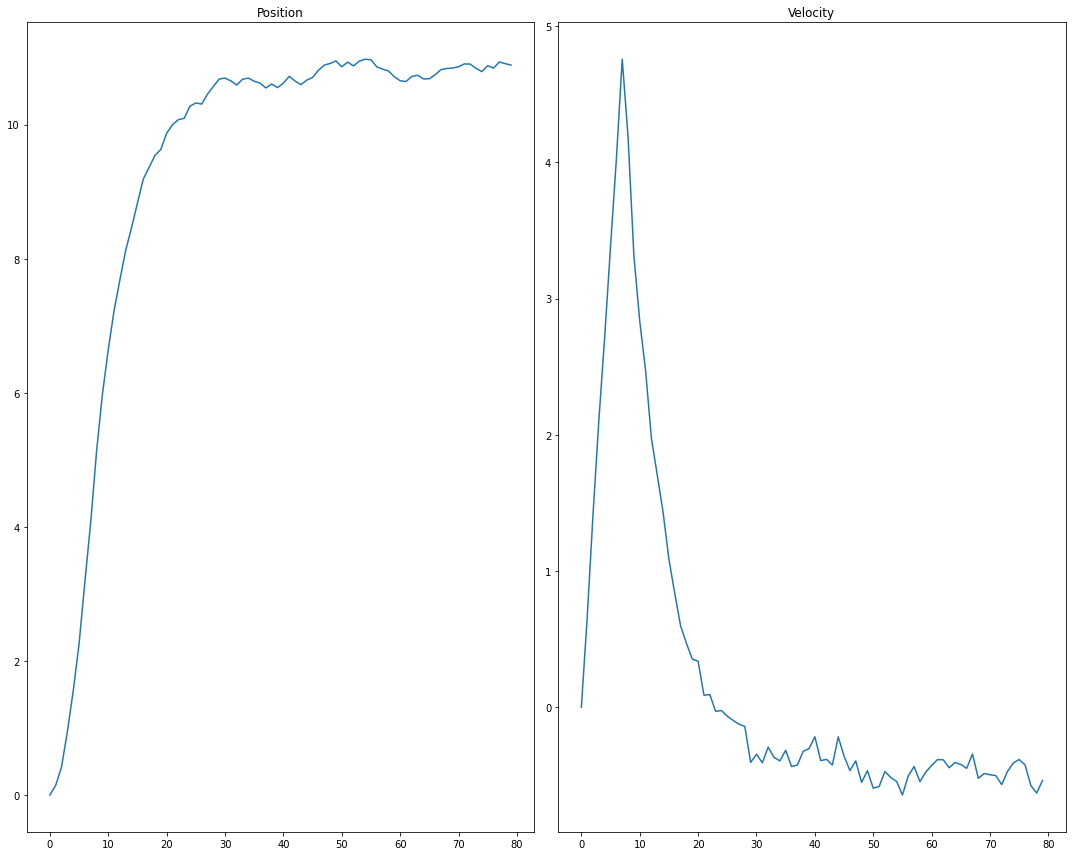

In [ ]:
import matplotlib.pyplot as plt

xhist = np.vstack(xhist_list)

fig, axs = plt.subplots(1, 2, figsize = (15,12))
axs[0].plot(xhist[:,0])
axs[0].set_title("Position")
axs[1].plot(xhist[:,1])
axs[1].set_title("Velocity")


fig.tight_layout()


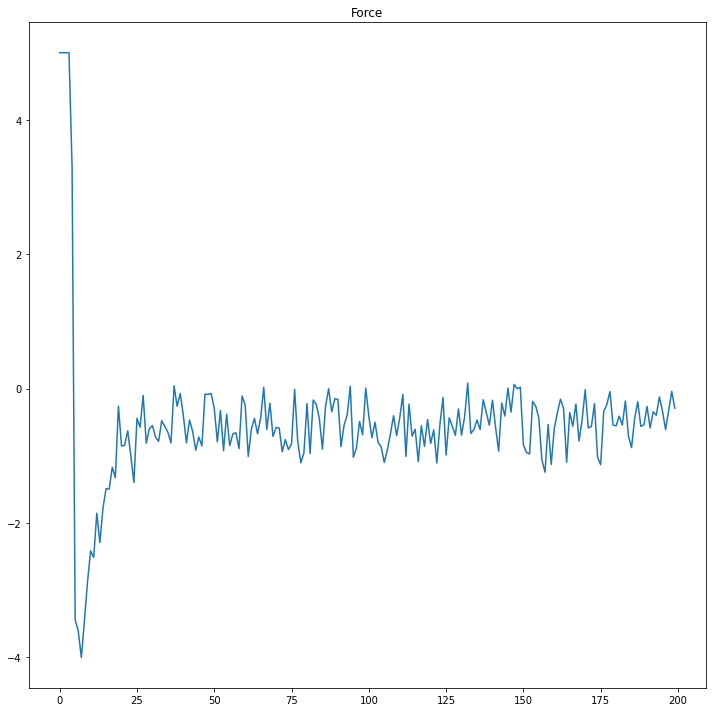

In [ ]:
import matplotlib.pyplot as plt

uhist = np.vstack(uhist_list)

fig, axs = plt.subplots(1, 1, figsize = (10,10))
axs.plot(uhist[:,0])
axs.set_title("Force")

fig.tight_layout()


## QP for MPC Implementation (CVXPY)

In [ ]:
def active_foot_contraint_builder_cvxpy(key,u,fmin,fmax,mu):
  """
  Generates contraints 1 foot at a time

  Args:
    u: control vector
    
    key: dictionary key for active foot

  Returns:
    foot_constraint

  """
  fz_idx_dict = {'FR': 2, 'FL': 5, 'BR':8, 'BL': 11}

  fz = u[fz_idx_dict[key]]
  fy = u[fz_idx_dict[key]-1]
  fx = u[fz_idx_dict[key]-2]

  foot_constraint = [
                    -mu*fz <= fx, fx <= mu*fz,
                    -mu*fz <= fy, fy <= mu*fz,
                    fmin <= fz, fz <= fmax
                     ]


  return foot_constraint

def inactive_foot_contraint_builder_cvxpy(key,u):
  """
  Generates contraints 1 foot at a time

  Args:
    u: control vector
    
    key: dictionary key for active foot

  Returns:
    foot_constraint

  """
  fz_idx_dict = {'FR': 2, 'FL': 5, 'BR':8, 'BL': 11}

  fz = u[fz_idx_dict[key]] 
  fy = u[fz_idx_dict[key]-1]
  fx = u[fz_idx_dict[key]-2]


  foot_constraint = [0 <= fx, fx <= 0,
                     0 <= fy, fy <= 0,
                     0 <= fz, fz <= 0]

  return foot_constraint

def feet_constraint_builder_cvxpy(active_feet_dict, u, k, fmin, fmax, mu):
  """
  Generates contraints 1 foot at a time

  Args:
    active_feet_dict: dict of active feet (active == 1, inactive == 0)
    u: control vector

  Returns:
    constraint_list: list of all control vector constraints

  """
  constraint_list = []

  for key in active_feet_dict:
    if active_feet_dict[key] == 1:
      constraint_list += active_foot_contraint_builder_cvxpy(key,u[:,k],fmin,fmax,mu)
    else:
      constraint_list += inactive_foot_contraint_builder_cvxpy(key,u[:,k])

  return constraint_list

In [ ]:
# Controller Settings and Robot Data
m = 43 # kg 
Ixx = 0.35 # kgm^2 
Iyy = 2.1 # kgm^2
Izz = 2.1 # kgm^2
mu = 0.6 # Coefficient of Friction
g_z = -9.8 # m/s^2

body_length = 0.6 # m
body_width = 0.256 # m
body_height = 0.2 #m
leg_link_lengths = 0.34 # m, both l1 and l2

tau_max = 250 # Nm
Θ_weight = 1
z_weight = 50
yaw_rate_weight = 1
v_weight = 1
alpha = 1e-6 # force_weight 
fmin = 10 # N
fmax = 666 # N

# Initialize Variables
psi = 0

# r is the vector from the center of mass (COM) to the point where the force is applied
r1 = np.array([0.5*body_length, -0.5*body_width, -body_height]) #FR
r2 = np.array([0.5*body_length, 0.5*body_width, - body_height]) #FL
r3 = np.array([-0.5*body_length, - 0.5*body_width, -body_height]) #BR
r4 = np.array([-0.5*body_length, 0.5*body_width, -body_height]) #BL

r = [r1,r2,r3,r4]

### with Gravity_State = False

In [ ]:
from scipy.linalg import expm


# Continuous Time Model
A = get_A(psi, gravity_state=False)
B = get_B(m, Ixx, Iyy, Izz, psi, r, gravity_state=False)
C = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,-9.8])

# Time step h for discritization
h = 1/36 

# Discrete time model of a quadruped

# Exponential Matrix
# Ad = sparse.csc_matrix(expm(A*h))
# Bd = sparse.csc_matrix(np.linalg.inv(A)*(np.eye(A.shape[0])-Ad)*B) # only works if A is nonsingular

# Euler Approx 
Ad = sparse.csc_matrix(np.eye(A.shape[0]) + A*h)
Bd = sparse.csc_matrix(B*h)
[nx, nu] = Bd.shape

Cd = C*h

# discrete = sp.signal.cont2discrete((A,B,0 ,0 ), h)

# Objective function
# Q and R are diagonal positive semidefinite matrices of weights
Q = sparse.diags([1., 1., 1., 1., 1., 50., 1., 1., 1., 1., 1., 1.])
QN = Q
R = alpha*sparse.eye(12)

# Initial and reference states
x0 = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,0.,0.])

xr = np.array([0.,0.,0.,0.5,0.5,body_height+0.2,0.,0.,0.,0.,0.,0.])


# Constraints
# xmin = np.array([-np.pi/6, #phi
#                  -np.pi/6, #theta
#                  -np.pi/6, #psi
#                  -np.inf,  #p_x
#                  -np.inf,  #p_y
#                  0,  #p_z
#                  -np.inf,  #omega_x
#                  -np.inf,  #omega_y
#                  -np.inf,  #omega_z
#                  -1.0,  #pdot_x
#                  -1.0,  #pdot_y
#                  -0.3,  #pdot_z
#                  ])       

# xmax = np.array([np.pi/6, #phi
#                  np.pi/6, #theta
#                  np.pi/6, #psi
#                  1.0,  #p_x
#                  1.0,  #p_y
#                  1.0,  #p_z
#                  np.inf,  #omega_x
#                  np.inf,  #omega_y
#                  np.inf,  #omega_z
#                  np.inf,  #pdot_x
#                  np.inf,  #pdot_y
#                  0.3,  #pdot_z
#                  ])       

xmin = np.array([-np.inf, #phi
                 -np.inf, #theta
                 -np.inf, #psi
                 -np.inf,  #p_x
                 -np.inf,  #p_y
                 -np.inf,  #p_z
                 -np.inf,  #omega_x
                 -np.inf,  #omega_y
                 -np.inf,  #omega_z
                 -np.inf,  #pdot_x
                 -np.inf,  #pdot_y
                 -np.inf,  #pdot_z
                 ])       

xmax = np.array([np.inf, #phi
                 np.inf, #theta
                 np.inf, #psi
                 np.inf,  #p_x
                 np.inf,  #p_y
                 np.inf,  #p_z
                 np.inf,  #omega_x
                 np.inf,  #omega_y
                 np.inf,  #omega_z
                 np.inf,  #pdot_x
                 np.inf,  #pdot_y
                 np.inf,  #pdot_z
                 ])       


active_feet_dict_1 = {'FR': 1, 'FL': 0, 'BR':0, 'BL': 1}
active_feet_dict_2 = {'FR': 0, 'FL': 1, 'BR':1, 'BL': 0}
# active_feet_dict_1 = {'FR': 1, 'FL': 1, 'BR':1, 'BL': 1}
# active_feet_dict_2 = {'FR': 1, 'FL': 1, 'BR':1, 'BL': 1}

trot_gait_list = [active_feet_dict_1,active_feet_dict_2]
gait_phase_len = 3

# Prediction horizon
N = 12 #set to 24 for 2 gait cycles if 1 gait cycle is .33 second with 12 timesteps

# Define problem
u = Variable((nu, N))
x = Variable((nx, N+1))

x_init = Parameter(nx)
objective = 0
constraints = [x[:,0] == x_init]

for k in range(N):
    objective += quad_form(x[:,k] - xr, Q) + quad_form(u[:,k], R) # Q and R are pos semidef matrices of weights
    constraints += [x[:,k+1] == Ad*x[:,k] + Bd*u[:,k] + Cd]
    constraints += [xmin <= x[:,k], x[:,k] <= xmax]

    phase_idx = (k//gait_phase_len)%len(trot_gait_list)
    #print(phase_idx)
    constraints += feet_constraint_builder_cvxpy(trot_gait_list[phase_idx], u, k, fmin, fmax, mu)

objective += quad_form(x[:,N] - xr, QN)
prob = Problem(Minimize(objective), constraints)


In [ ]:
x0 = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,0.,0.])

# Simulate in closed loop
sim_time = 1 #seconds
nsim = int(sim_time/h)

xhist_list = []
uhist_list = []

for i in range(nsim):
    x_init.value = x0
    
    prob.solve(solver=OSQP, warm_start=True, polish=1)

    xhist_list.append(x0)
    uhist_list.append(u[:,0].value)

    x0 = Ad.dot(x0) + Bd.dot(u[:,0].value) + Cd #+ 0.001*np.random.uniform(-1, 1, 12)
    # resolve for Ad and Bd
    # recalculate contraints based on x0 and current u?
    #prob.update    


In [ ]:
prob.solver_stats.num_iters, prob.solver_stats.setup_time, prob.solver_stats.solve_time, prob.solver_stats.extra_stats.info.polish_time, prob.solver_stats.solver_name

(25, None, 0.00124865, 'OSQP')

In [ ]:
# Plot State History
x_ref_list = [xr]
state_hist_plots(xhist_list,x_ref_list,nsim,h)

In [ ]:
# Plot Control History
control_hist_plots(uhist_list,nsim,h)

### with Gravity_State = True

In [ ]:
from scipy.linalg import expm

# Continuous Time Model
A = get_A(psi, gravity_state=True)


B = get_B(m, Ixx, Iyy, Izz, psi, r, gravity_state=True)



#C = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,-9.8])

# Time step h for discritization
h = 1/30 

# Discrete time model of a quadruped

# Exponential Matrix
# Ad = sparse.csc_matrix(expm(A*h))
# Bd = sparse.csc_matrix(np.linalg.inv(A)*(np.eye(A.shape[0])-Ad)*B) # only works if A is nonsingular

# Euler Approx 
Ad = sparse.csc_matrix(np.eye(A.shape[0]) + A*h)
Bd = sparse.csc_matrix(B*h)
[nx, nu] = Bd.shape


# discrete = sp.signal.cont2discrete((A,B,0 ,0 ), h)

# Objective function
# Q and R are diagonal positive semidefinite matrices of weights
Q = sparse.diags([1., 1., 1., 1., 1., 50., 1., 1., 1., 1., 1., 1.,1.])
QN = Q
R = alpha*sparse.eye(12)

# Initial and reference states
x0 = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,0.,0.,-9.81])

xr = np.array([0.,0.,0.,0.,0.,body_height+0.2,0.,0.,0.,0.,0.,0.,-9.81])


# Constraints
xmin = np.array([-np.pi/6, #phi
                 -np.pi/6, #theta
                 -np.pi/6, #psi
                 -np.inf,  #p_x
                 -np.inf,  #p_y
                 0,  #p_z
                 -np.inf,  #omega_x
                 -np.inf,  #omega_y
                 -np.inf,  #omega_z
                 -np.inf,  #pdot_x
                 -np.inf,  #pdot_y
                 -np.inf,  #pdot_z
                 -9.81  # gz
                 ])       

xmax = np.array([np.pi/6, #phi
                 np.pi/6, #theta
                 np.pi/6, #psi
                 np.inf,  #p_x
                 np.inf,  #p_y
                 np.inf,  #p_z
                 np.inf,  #omega_x
                 np.inf,  #omega_y
                 np.inf,  #omega_z
                 np.inf,  #pdot_x
                 np.inf,  #pdot_y
                 np.inf,  #pdot_z
                 9.81  # gz
                 ])       

# xmin = np.array([-np.inf, #phi
#                  -np.inf, #theta
#                  -np.inf, #psi
#                  -np.inf,  #p_x
#                  -np.inf,  #p_y
#                  -np.inf,  #p_z
#                  -np.inf,  #omega_x
#                  -np.inf,  #omega_y
#                  -np.inf,  #omega_z
#                  -np.inf,  #pdot_x
#                  -np.inf,  #pdot_y
#                  -np.inf,  #pdot_z
#                  -np.inf  # gz
#                  ])       

# xmax = np.array([np.inf, #phi
#                  np.inf, #theta
#                  np.inf, #psi
#                  np.inf,  #p_x
#                  np.inf,  #p_y
#                  np.inf,  #p_z
#                  np.inf,  #omega_x
#                  np.inf,  #omega_y
#                  np.inf,  #omega_z
#                  np.inf,  #pdot_x
#                  np.inf,  #pdot_y
#                  np.inf,  #pdot_z
#                  np.inf  # gz
#                  ])       


active_feet_dict = {'FR': 1, 'FL': 1, 'BR':1, 'BL': 1}

# Prediction horizon
N = 12 #set to 20 for 2 gait cycles if 1 gait cycle is .32 second with 16 timesteps

# Define problem
u = Variable((nu, N))
x = Variable((nx, N+1))

x_init = Parameter(nx)
objective = 0
constraints = [x[:,0] == x_init]

for k in range(N):
    objective += quad_form(x[:,k] - xr, Q) + quad_form(u[:,k], R) # Q and R are pos semidef matrices of weights
    constraints += [x[:,k+1] == Ad*x[:,k] + Bd*u[:,k]]
    #constraints += [xmin <= x[:,k], x[:,k] <= xmax]
    constraints += feet_constraint_builder_cvxpy(active_feet_dict, u, fmin, fmax, mu)

objective += quad_form(x[:,N] - xr, QN)
prob = Problem(Minimize(objective), constraints)


In [ ]:
x0 = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,0.,0.,-9.81])

# Simulate in closed loop
sim_time = 1 #seconds
nsim = int(sim_time/h)

xhist_list = []
uhist_list = []

for i in range(nsim):
    x_init.value = x0
    
    prob.solve(solver=OSQP, warm_start=True)

    xhist_list.append(x0)
    uhist_list.append(u[:,0].value)

    x0 = Ad.dot(x0) + Bd.dot(u[:,0].value) 
    # resolve for Ad and Bd
    # recalculate contraints based on x0
    #prob.update    


In [ ]:
# Plot State History
x_ref_list = [xr]
state_hist_plots(xhist_list,x_ref_list,nsim,h)

In [ ]:
# Plot Control History
control_hist_plots(uhist_list,nsim,h)

## Quadruped Nonlinear Dynamics

In [ ]:
def get_R(x):
  """
  Args:
    x: state vector with the first 3 elements being the euler angles
      euler_angles = jnp.array([roll, pitch, yaw])
                                phi,theta,psi
  Return:
    R: Rotation from body to world coordinates
      Rz(yaw)*Ry(pitch)*Rx(roll)

  """

  # R = jnp.array([[jnp.cos(x[2])*jnp.cos(x[1]), -jnp.sin(x[0])*jnp.cos(x[1]), jnp.sin(x[1])], 
  #              [jnp.sin(x[0])*jnp.cos(x[2])*jnp.sin(x[1]) + jnp.cos(x[0])*jnp.sin(x[2]),  jnp.cos(x[0])*jnp.cos(x[2]) - jnp.sin(x[0])*jnp.sin(x[2])*jnp.sin(x[1]), -jnp.sin(x[0])*jnp.cos(x[1])],
  #              [jnp.sin(x[0])*jnp.sin(x[2]) - jnp.cos(x[1])*jnp.cos(x[2])*jnp.sin(x[1]),  jnp.cos(x[0])*jnp.sin(x[2])*jnp.sin(x[1]) + jnp.sin(x[0])*jnp.cos(x[2]), jnp.cos(x[1])*jnp.cos(x[0])]])
  
  # R_full_paper = jnp.array([[jnp.cos(x[1])*jnp.cos(x[2]), -jnp.sin(x[2]), 0], 
  #              [jnp.cos(x[1])*jnp.sin(x[2]), jnp.cos(x[2]), 0],
  #              [0,            0,           1]])
  
  # R_approx = jnp.array([[jnp.cos(x[2]), jnp.sin(x[2]), 0], # Rz approx for R
  #              [-jnp.sin(x[2]), jnp.cos(x[2]), 0],
  #              [0,            0,           1]])

  Rx = jnp.array([[1,              0,             0], 
                  [0, jnp.cos(x[0]), -jnp.sin(x[0])],
                  [0, jnp.sin(x[0]), jnp.cos(x[0])]])


  Ry = jnp.array([[jnp.cos(x[1]),  0, jnp.sin(x[1])], 
                  [0,              1,             0],
                  [-jnp.sin(x[1]), 0, jnp.cos(x[1])]])


  Rz = jnp.array([[jnp.cos(x[2]), -jnp.sin(x[2]), 0], 
                  [jnp.sin(x[2]), jnp.cos(x[2]),  0],
                  [0,             0,              1]])
  


  Rbw = Rz@Ry@Rx



  return Rbw   # R, Rbw, R_approx, R_full_paper

In [ ]:
def get_I(Ixx, Iyy, Izz, R, x):
  """
    Args: 
      Ixx, Iyy, Izz: Inertia components in body coordinates
      x: state vector with the first 3 elements being the euler angles, 
        note: euler angles can be obtained from cvxpy state variable as x.item(0),x.item(1),x.item(2)

    Return:
      I : Inertia tensor in the world coordinate system
  """

  # Inertia tensor in body coordinates
  I_B = jnp.array([[Ixx, 0,   0],
                  [0,   Iyy, 0],
                  [0,   0,   Izz]])
  
  I = R*I_B*jnp.transpose(R) 

  return I

In [ ]:
def quadruped_dynamics(x,u):
  """
  Args:
    
    x: State Vector
      np.vstack([Θ, p, omega, p_dot])
    
    u: Control Vector
      np.vstack([f1,f2,f3,f4])

  Return:

    x_dot: 
       np.vstack([Θ_dot, p_dot, omega_dot, p_ddot])
  """
  m = 43 # kg 
  Ixx = 0.41 # kgm^2 
  Iyy = 2.1 # kgm^2
  Izz = 2.1 # kgm^2
  g_z = -9.81 # m/s^2
  
  # Full Rotation matrix, representing the transform from body to world coordinates
  R = get_R(x) 
  # Inertia tensor in the world coordinate system
  I = get_I(Ixx, Iyy, Izz, R, x)

  I_inv = jnp.linalg.inv(I)
  id_3 = jnp.eye(3)

  # r is the vector from the center of mass (COM) to the point where the force is applied
  r1 = jnp.array([0.5*body_length, -0.5*body_width, -body_height]) #FR
  r2 = jnp.array([0.5*body_length, 0.5*body_width, - body_height]) #FL
  r3 = jnp.array([-0.5*body_length, - 0.5*body_width, -body_height]) #BR
  r4 = jnp.array([-0.5*body_length, 0.5*body_width, -body_height]) #BL
  r = [r1,r2,r3,r4]

  theta_dot = R@x[6:9]
  #print("theta_dot shape:", theta_dot.shape)
  p_dot = x[9:]
  #print("p_dot shape:", p_dot.shape)
  omega_dot = I_inv@hatmap(r[0])@u[0:3] + I_inv@hatmap(r[1])@u[3:6] + I_inv@hatmap(r[2])@u[6:9] + I_inv@hatmap(r[3])@u[9:]
  #print("omega_dot shape:", omega_dot.shape)
  p_ddot = id_3/m@u[0:3] + id_3/m@u[3:6] + id_3/m@u[6:9] + id_3/m@u[9:] + jnp.array([0,0,g_z])
  #print("p_ddot shape:", p_ddot.shape)

  return jnp.hstack([theta_dot, p_dot, omega_dot, p_ddot])

In [ ]:
def quadruped_rk4_step(x,u):
  """
  Args:
    x: state vector
    u: control vector
    h: time step

  Return:
    rk4 step
  """

  k1 = quadruped_dynamics(x,u)
  k2 = quadruped_dynamics(x + h*k1/2,u)
  k3 = quadruped_dynamics(x + h*k2/2,u)
  k4 = quadruped_dynamics(x + h*k3,u)

  return x + h*(k1+2*k2+2*k3+k4)/6

In [ ]:
import jax
import jax.numpy as jnp
# Get Discrete Time A and B about standing position 
# Then attempt to get approximated linear dynamics about other possible stable points in trotting gait

body_height = 0.3 #m
m = 43 # kg
g_z = -9.81 # m/s^2

h = 1/36

x_rest = jnp.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,0.,0.])
#x_rest = jnp.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])
u_rest = jnp.array([0, 0, -m*g_z/4, 0, 0, -m*g_z/4, 0, 0, -m*g_z/4, 0, 0, -m*g_z/4])
#u_rest = jnp.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

A_d = jax.jacfwd(quadruped_rk4_step, argnums=[0])(x_rest,u_rest) 
B_d = jax.jacfwd(quadruped_rk4_step, argnums=[1])(x_rest,u_rest) # Something is wrong with B_d, top half of matrix should be zeros


In [ ]:
import osqp
import numpy as np
import scipy as sp
from scipy import sparse

# Time step h for discritization
h = 1/36 

# Discrete time model of a quadruped
Ad = A_d
Bd = B_d
[nx, nu] = Bd.shape

# Objective function
# Q and R are diagonal positive semidefinite matrices of weights
Q = sparse.diags([1., 1., 1., 1., 1., 50., 1., 1., 1., 1., 1., 1.])
QN = Q
R = alpha*sparse.eye(12)

# Initial and reference states
x0 = np.array([0.,0.,0.,0.,0.,body_height,0.,0.,0.,0.,0.,0.])

#xr = np.array([0.,0.,0.,5.,5.,body_height+0.2,0.,0.,-1.0,1.,1.,0.])

xr = np.array([0.,0.,0.,1.,0.,body_height,0.,0.,0.,0.,0.,0.])

# Constraints
# xmin = np.array([-np.pi/6, #phi
#                  -np.pi/6, #theta
#                  -np.pi/6, #psi
#                  -np.inf,  #p_x
#                  -np.inf,  #p_y
#                  body_height-.1,  #p_z
#                  -np.inf,  #omega_x
#                  -np.inf,  #omega_y
#                  -np.inf,  #omega_z
#                  -6.0,  #pdot_x
#                  -2.0,  #pdot_y
#                  -2.0,  #pdot_z
#                  ])       

# xmax = np.array([np.pi/6, #phi
#                  np.pi/6, #theta
#                  np.pi/6, #psi
#                  np.inf,  #p_x
#                  np.inf,  #p_y
#                  body_height+.2,  #p_z
#                  np.inf,  #omega_x
#                  np.inf,  #omega_y
#                  np.inf,  #omega_z
#                  6.0,  #pdot_x
#                  2.0,  #pdot_y
#                  2.0,  #pdot_z
#                  ])       

xmin = np.array([-np.inf, #phi
                 -np.inf, #theta
                 -np.inf, #psi
                 -np.inf,  #p_x
                 -np.inf,  #p_y
                 0,  #p_z
                 -np.inf,  #omega_x
                 -np.inf,  #omega_y
                 -np.inf,  #omega_z
                 -np.inf,  #pdot_x
                 -np.inf,  #pdot_y
                 -np.inf,  #pdot_z
                 ])       

xmax = np.array([np.inf, #phi
                 np.inf, #theta
                 np.inf, #psi
                 np.inf,  #p_x
                 np.inf,  #p_y
                 np.inf,  #p_z
                 np.inf,  #omega_x
                 np.inf,  #omega_y
                 np.inf,  #omega_z
                 np.inf,  #pdot_x
                 np.inf,  #pdot_y
                 np.inf,  #pdot_z
                 ])       



umin = np.array([-np.inf,  #FR_x
                 -np.inf,  #FR_y
                 fmin,     #FR_z
                 -np.inf,  #FL_x
                 -np.inf,  #FL_y
                 fmin,     #FL_z
                 -np.inf,  #BR_x
                 -np.inf,  #BR_y
                 fmin,     #BR_z
                 -np.inf,  #BL_x
                 -np.inf,  #BL_y
                 fmin,     #BL_z
                 ])   

umax = np.array([np.inf,  #FR_x
                 np.inf,  #FR_y
                 fmax,    #FR_z
                 np.inf,  #FL_x
                 np.inf,  #FL_y
                 fmax,    #FL_z
                 np.inf,  #BR_x
                 np.inf,  #BR_y
                 fmax,    #BR_z
                 np.inf,  #BL_x
                 np.inf,  #BL_y
                 fmax,    #BL_z
                 ])   


# Prediction horizon
N = 12 #set to 12 for 2 gait cycles if 1 gait cycle is .33 second 


# Convert problem to a QP for OSQP, used for solving convex quadratic programs 
# - quadratic objective
P = sparse.block_diag([sparse.kron(sparse.eye(N), Q), QN,
                       sparse.kron(sparse.eye(N), R)], format='csc')
# - linear objective
q = np.hstack([np.kron(np.ones(N), -Q.dot(xr)), -QN.dot(xr),np.zeros(N*nu)])

# - linear dynamics #to use OSQP form gravity term has to be built into state?
Ax = get_Ax([Ad],nx,N)
Bu = get_Bu([Bd],nx,nu,N)
Aeq = sparse.hstack([Ax, Bu])
leq = np.hstack([-x0, np.zeros(N*nx)])
ueq = leq

# - input and state constraints
Aineq = sparse.eye((N+1)*nx + N*nu)
lineq = np.hstack([np.kron(np.ones(N+1), xmin), np.kron(np.ones(N), umin)])
uineq = np.hstack([np.kron(np.ones(N+1), xmax), np.kron(np.ones(N), umax)])

# - OSQP constraints
A = sparse.vstack([Aeq, Aineq], format='csc')
l = np.hstack([leq, lineq])
u = np.hstack([ueq, uineq])

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace
prob.setup(P, q, A, l, u, warm_start=True, verbose = False, polish=1)

# Trotting Gait (2-Phase)
phase_1 = [umin1,umax1]
phase_2 = [umin2,umax2]

gait_phase = [phase_1,phase_2]
gait_phase_len = 3 # num time steps to complete a phase in the gait cycle, 
                   # if N = 12, and gait has 2 phases, gait_phase_len = 3
                   # means horizon will include 2 gait cycles


# Simulate in closed loop
sim_time = .5 #seconds
nsim = int(sim_time/h)

xhist_list = []
uhist_list = []

# First solve in loop is for stationary robot with all feet active 
# and only enforces state constraints normal force control constraints
# since control horizon is not yet determined
for i in range(nsim):
    # Solve
    res = prob.solve()

    # Check solver status
    if res.info.status != 'solved':
        raise ValueError('OSQP did not solve the problem!')

    xhist_list.append(x0)

    # Apply first control input 
    ctrl = res.x[-N*nu:-(N-1)*nu] # res.x contains future states and controls in horizon
    #x0 = Ad.dot(x0) + Bd.dot(ctrl) #+ Cd #+ 0.2*np.random.rand(12)

    x0 = quadruped_rk4_step(x0,u_rest+ctrl)

    uhist_list.append(u_rest+ctrl)

    # Update initial state
    l[:nx] = -x0
    u[:nx] = -x0

    # Update inequality contraints for horizon
    # new_l, new_u = feet_constraint_builder_osqp(gait_phase, gait_phase_len, N, i-1, res.x)
    # l[-nu*N:] = new_l
    # u[-nu*N:] = new_u

    prob.update(l=l, u=u)

In [ ]:
res.info.solve_time, res.info.setup_time, res.info.run_time, res.info.status_val, res.info.status_polish, res.info.status

(0.00059862, 0.001158648, 0.001012909, 1, -1, 'solved')

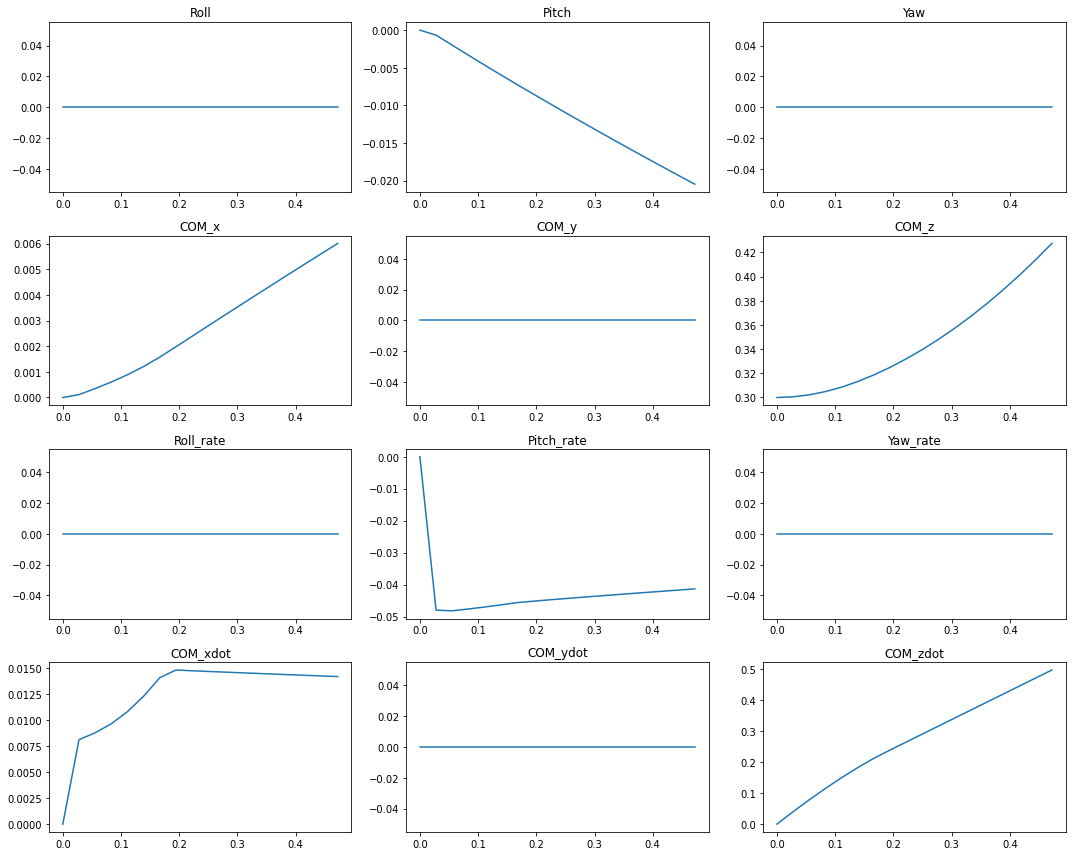

In [ ]:
import matplotlib.pyplot as plt

t = np.arange(nsim)*h

xhist = np.vstack(xhist_list)

fig, axs = plt.subplots(4, 3, figsize = (15,12))
axs[0, 0].plot(t,xhist[:,0])
axs[0, 0].set_title("Roll")
axs[0, 1].plot(t,xhist[:,1])
axs[0, 1].set_title("Pitch")
axs[0, 2].plot(t,xhist[:,2])
axs[0, 2].set_title("Yaw")

axs[1, 0].plot(t,xhist[:,3])
axs[1, 0].set_title("COM_x")
axs[1, 1].plot(t,xhist[:,4])
axs[1, 1].set_title("COM_y")
axs[1, 2].plot(t,xhist[:,5])
axs[1, 2].set_title("COM_z")

axs[2, 0].plot(t,xhist[:,6])
axs[2, 0].set_title("Roll_rate")
axs[2, 1].plot(t,xhist[:,7])
axs[2, 1].set_title("Pitch_rate")
axs[2, 2].plot(t,xhist[:,8])
axs[2, 2].set_title("Yaw_rate")

axs[3, 0].plot(t,xhist[:,9])
axs[3, 0].set_title("COM_xdot")
axs[3, 1].plot(t,xhist[:,10])
axs[3, 1].set_title("COM_ydot")
axs[3, 2].plot(t,xhist[:,11])
axs[3, 2].set_title("COM_zdot")

fig.tight_layout()


CoM_z should not be rising uncontrollably

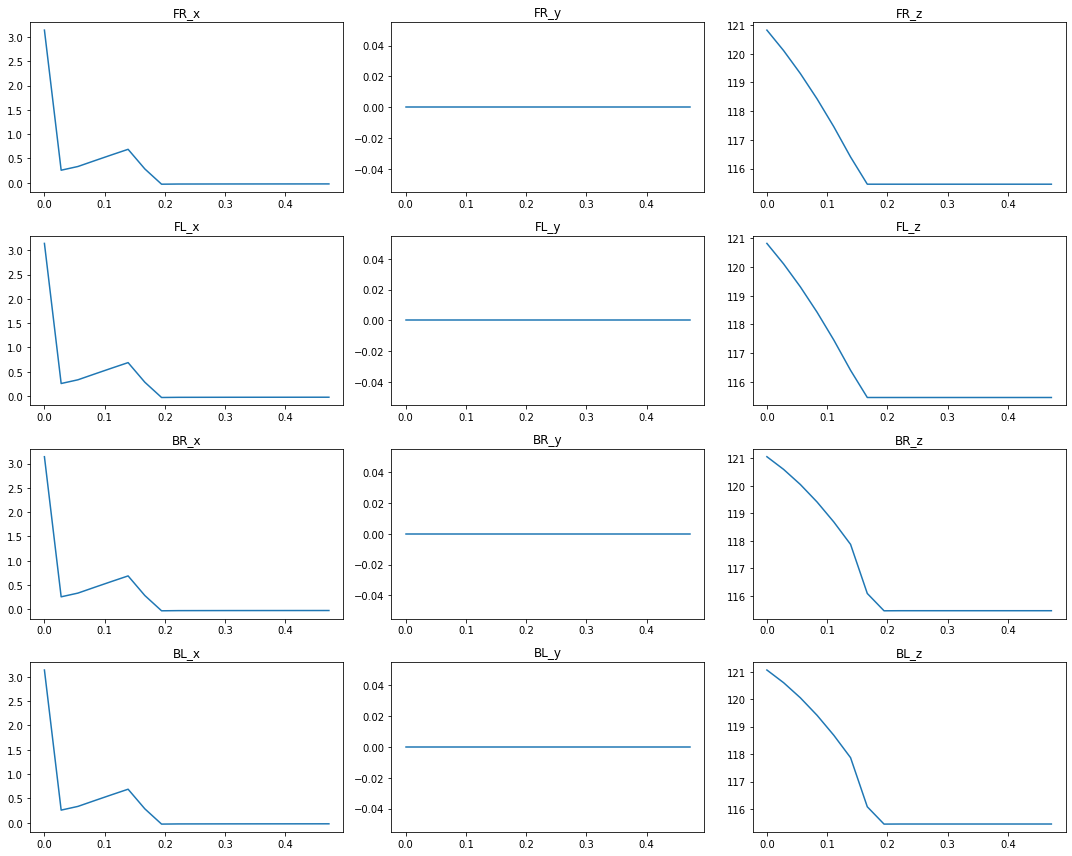

In [ ]:
import matplotlib.pyplot as plt

uhist = np.vstack(uhist_list)

fig, axs = plt.subplots(4, 3, figsize = (15,12))
axs[0, 0].plot(t,uhist[:,0])
axs[0, 0].set_title("FR_x")
axs[0, 1].plot(t,uhist[:,1])
axs[0, 1].set_title("FR_y")
axs[0, 2].plot(t,uhist[:,2])
axs[0, 2].set_title("FR_z")

axs[1, 0].plot(t,uhist[:,3])
axs[1, 0].set_title("FL_x")
axs[1, 1].plot(t,uhist[:,4])
axs[1, 1].set_title("FL_y")
axs[1, 2].plot(t,uhist[:,5])
axs[1, 2].set_title("FL_z")

axs[2, 0].plot(t,uhist[:,6])
axs[2, 0].set_title("BR_x")
axs[2, 1].plot(t,uhist[:,7])
axs[2, 1].set_title("BR_y")
axs[2, 2].plot(t,uhist[:,8])
axs[2, 2].set_title("BR_z")

axs[3, 0].plot(t,uhist[:,9])
axs[3, 0].set_title("BL_x")
axs[3, 1].plot(t,uhist[:,10])
axs[3, 1].set_title("BL_y")
axs[3, 2].plot(t,uhist[:,11])
axs[3, 2].set_title("BL_z")

fig.tight_layout()


## Functions to Work on

In [ ]:
def get_hip_location(roll,pitch,yaw,CoM):

  # Pitch (+front, -back)
  # Roll (+left, -right)
  # Yaw(-left, +right)

  # foot is an index 0,1,2,3 
  # corresponding to FR, FL, BR, BL

  # Get hip locations
  # Hip location from com state and euler angles -> desirable future footstep location is nominal scheduled contact phase = gait_phase_len*h

  # can get hip location relative to current states CoM


In [ ]:
def raibert_update(h, foot_idx, com_vel):
  # h is discritization time in hz
  # since gait cycle is 1/3 s and has 2 phases
  # nominal_scheduled_contact_phase = 1/h/3/2

  nominal_scheduled_contact_phase = 1/(6*h)
  new_foot_loc = get_hip_location(feet[foot_idx]) + nominal_scheduled_contact_phase/2*com_vel

  return new_foot_loc


In [ ]:

# r is the vector from the center of mass (COM) to the point where the force is applied
r1 = np.array([update[0][0] + 0.5*body_length, update[0][1] - 0.5*body_width, update[0][2] - body_height]) #FR
r2 = np.array([update[1][0] + 0.5*body_length, update[1][1] + 0.5*body_width, update[1][2] - body_height]) #FL
r3 = np.array([update[2][0] - 0.5*body_length, update[2][1] - 0.5*body_width, update[2][2] - body_height]) #BR
r4 = np.array([update[3][0] - 0.5*body_length, update[3][1] + 0.5*body_width, update[3][2] - body_height]) #BL

r = [r1,r2,r3,r4]

# I need r to calculate B, r is defined relative to CoM, I do not have body sensors for the true position, 
# but estimated with raibert heuristic by getting hip position update from euler angles

In [ ]:
def get_Foot_Jacobian(l_calf,l_thigh,l_hip, joint_angles):
  """
  To Do: Need Swing Leg Scheduler for Joint angles first
  """


  